# Neural Network using tensorflow
for this model whe used some information from "https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/"

In [1]:
# import libraries
import tensorflow.keras as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
keggle = True

## Load the data


In [3]:
# load data
if keggle:
    test_df = pd.read_csv('data/keggle_test_data.csv')
    test_df = test_df.drop('Unnamed: 0', axis=1)

    train_df = pd.read_csv('data/keggle_train_data.csv')
    train_df = train_df.drop('Unnamed: 0', axis=1)

else:
    test_df = pd.read_csv('data/clean_test_data.csv')
    test_df = test_df.drop('Unnamed: 0', axis=1)

    train_df = pd.read_csv('data/clean_train_data.csv')
    train_df = train_df.drop('Unnamed: 0', axis=1)


display(test_df)
display(train_df)

,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,0,0,0,0,1,0,0,0,0,0,...,-0.742060,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.816513,1.678499,5.387390
1,0,0,0,0,0,0,0,0,0,1,...,0.935952,-0.200579,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-1.184969,1.678499,5.278525
2,0,0,0,0,0,0,0,0,0,0,...,-0.742060,-0.704493,2.292105,-0.103134,-0.285354,-0.063031,-0.089422,-0.816513,1.678499,5.329398
3,0,0,0,0,0,0,0,0,0,1,...,0.500618,0.540470,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.816513,1.678499,5.245266
4,0,0,0,0,1,0,0,0,0,0,...,0.777649,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-1.553425,1.678499,5.234264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0,0,0,0,0,0,0,0,0,0,...,-0.742060,1.148131,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.448057,-1.360118,5.214844
729,0,1,0,0,0,0,0,0,0,0,...,-0.742060,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.448057,-1.360118,4.899821
730,0,1,0,0,0,0,0,0,0,0,...,-0.742060,-0.200579,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.079602,-1.360118,4.900367
731,0,0,0,0,0,0,0,0,0,0,...,-0.108848,-0.230221,-0.358838,-0.103134,-0.285354,-0.063031,1.146786,0.288854,-1.360118,5.120574


,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,0,0,0,0,1,0,0,0,0,0,...,0.920121,0.214409,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.448057,1.678499,5.332438
1,0,0,0,0,1,0,0,0,0,0,...,0.366061,-0.704493,-0.358838,-0.103134,1.854530,-0.063031,-0.089422,-0.079602,1.678499,5.021189
2,0,0,0,0,1,0,0,0,0,0,...,2.368594,-0.170937,-0.358838,-0.103134,-0.285354,-0.063031,21.985725,-0.079602,1.678499,5.235528
3,0,0,0,0,0,0,0,0,0,1,...,2.107394,-0.170937,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.079602,1.678499,5.291147
4,0,0,0,0,0,0,0,0,0,0,...,-0.742060,0.510828,-0.358838,-0.103134,2.282507,-0.063031,-0.089422,-1.921881,1.678499,5.282169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,0,0,0,0,1,0,0,0,0,0,...,1.592909,-0.096832,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.448057,-1.360118,5.204120
2193,0,0,0,0,1,0,0,0,0,0,...,3.009721,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,1.025766,-1.360118,5.117271
2194,0,0,0,0,0,0,0,0,0,0,...,0.207758,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-1.184969,-1.360118,5.153815
2195,0,0,0,0,1,0,0,0,0,0,...,0.556024,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.079602,-1.360118,5.117271


In [4]:
# split data into input X and target Y
target_train = train_df['SalePrice']
target_test = test_df['SalePrice']

input_train = train_df.drop('SalePrice', axis=1)
input_test = test_df.drop('SalePrice', axis=1)

display(test_df)
display(train_df)

,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,0,0,0,0,1,0,0,0,0,0,...,-0.742060,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.816513,1.678499,5.387390
1,0,0,0,0,0,0,0,0,0,1,...,0.935952,-0.200579,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-1.184969,1.678499,5.278525
2,0,0,0,0,0,0,0,0,0,0,...,-0.742060,-0.704493,2.292105,-0.103134,-0.285354,-0.063031,-0.089422,-0.816513,1.678499,5.329398
3,0,0,0,0,0,0,0,0,0,1,...,0.500618,0.540470,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.816513,1.678499,5.245266
4,0,0,0,0,1,0,0,0,0,0,...,0.777649,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-1.553425,1.678499,5.234264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0,0,0,0,0,0,0,0,0,0,...,-0.742060,1.148131,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.448057,-1.360118,5.214844
729,0,1,0,0,0,0,0,0,0,0,...,-0.742060,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.448057,-1.360118,4.899821
730,0,1,0,0,0,0,0,0,0,0,...,-0.742060,-0.200579,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.079602,-1.360118,4.900367
731,0,0,0,0,0,0,0,0,0,0,...,-0.108848,-0.230221,-0.358838,-0.103134,-0.285354,-0.063031,1.146786,0.288854,-1.360118,5.120574


,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,0,0,0,0,1,0,0,0,0,0,...,0.920121,0.214409,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.448057,1.678499,5.332438
1,0,0,0,0,1,0,0,0,0,0,...,0.366061,-0.704493,-0.358838,-0.103134,1.854530,-0.063031,-0.089422,-0.079602,1.678499,5.021189
2,0,0,0,0,1,0,0,0,0,0,...,2.368594,-0.170937,-0.358838,-0.103134,-0.285354,-0.063031,21.985725,-0.079602,1.678499,5.235528
3,0,0,0,0,0,0,0,0,0,1,...,2.107394,-0.170937,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.079602,1.678499,5.291147
4,0,0,0,0,0,0,0,0,0,0,...,-0.742060,0.510828,-0.358838,-0.103134,2.282507,-0.063031,-0.089422,-1.921881,1.678499,5.282169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,0,0,0,0,1,0,0,0,0,0,...,1.592909,-0.096832,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.448057,-1.360118,5.204120
2193,0,0,0,0,1,0,0,0,0,0,...,3.009721,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,1.025766,-1.360118,5.117271
2194,0,0,0,0,0,0,0,0,0,0,...,0.207758,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-1.184969,-1.360118,5.153815
2195,0,0,0,0,1,0,0,0,0,0,...,0.556024,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.079602,-1.360118,5.117271


In [5]:
# convert the pandas dataframes to numpy ndarrays
X_train = input_train.to_numpy()
X_test = input_test.to_numpy()
y_train = target_train.to_numpy()
y_test = target_test.to_numpy()

# find number of features
n_features = input_train.shape[1]

## Build the model
The code that is written computes its own neural network models and picks the best out of it. We continue with that model.

In [6]:
def build_model(hp):
    """
    This function computes a/the best neural network for the given data. 
    It makes a model by tuning the layers and parameters of the layers for 
    the amount of trials given in the tuner variable.
    
    source: "https://keras.io/guides/keras_tuner/getting_started/"
    """
    
    # metrics for the layers
    m1 = tf.metrics.RootMeanSquaredError()
    m2 = 'mean_absolute_percentage_error'
    
    # compute a model
    model = Sequential()
    
    # tune number of layers
    for i in range(hp.Int("numlayers", 1, 4)):
        model.add(
            Dense(
                # Tune number of units separately.
                units=hp.Int(f"units{i}", min_value=16, max_value=256, step=16),
                activation=hp.Choice("activation", ["relu", "leaky_relu", "elu", "tanh"])),
            )
        
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))
        
    # check if batch normalization is benneficial
    if hp.Boolean("bn_after_act"):
        model.add(BatchNormalization())
        
    # output layer
    model.add(Dense(1))
    
    model.compile(optimizer='Adam', loss=tf.metrics.mean_squared_error, metrics=[m1, m2])
    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory="data",
    project_name="Milestone_3"
)

# train the models with the given data
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 100 Complete [00h 00m 02s]
val_loss: 0.09027029946446419

Best val_loss So Far: 0.004205078585073352
Total elapsed time: 00h 04m 54s
INFO:tensorflow:Oracle triggered exit


In [7]:
# fit the best model
best_model.fit(X_train, y_train,
          batch_size=32, epochs=200,
          validation_data=(X_test, y_test))

Epoch 1/200
69/69 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0562 - mean_absolute_percentage_error: 0.7619 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610 - val_mean_absolute_percentage_error: 0.7740
Epoch 2/200
69/69 [==============================] - 0s 2ms/step - loss: 0.0029 - root_mean_squared_error: 0.0534 - mean_absolute_percentage_error: 0.7247 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601 - val_mean_absolute_percentage_error: 0.7692
Epoch 3/200
69/69 [==============================] - 0s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - mean_absolute_percentage_error: 0.6941 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585 - val_mean_absolute_percentage_error: 0.7454
Epoch 4/200
69/69 [==============================] - 0s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - mean_absolute_percentage_error: 0.6693 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575 - val_mean_absolu

Epoch 33/200
69/69 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - mean_absolute_percentage_error: 0.4435 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_percentage_error: 0.7034
Epoch 34/200
69/69 [==============================] - 0s 2ms/step - loss: 9.8887e-04 - root_mean_squared_error: 0.0314 - mean_absolute_percentage_error: 0.4395 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 0.7115
Epoch 35/200
69/69 [==============================] - 0s 2ms/step - loss: 9.1372e-04 - root_mean_squared_error: 0.0302 - mean_absolute_percentage_error: 0.4161 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_percentage_error: 0.7267
Epoch 36/200
69/69 [==============================] - 0s 2ms/step - loss: 9.2671e-04 - root_mean_squared_error: 0.0304 - mean_absolute_percentage_error: 0.4196 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558 -

69/69 [==============================] - 0s 3ms/step - loss: 6.2529e-04 - root_mean_squared_error: 0.0250 - mean_absolute_percentage_error: 0.3579 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582 - val_mean_absolute_percentage_error: 0.7742
Epoch 65/200
69/69 [==============================] - 0s 2ms/step - loss: 5.2188e-04 - root_mean_squared_error: 0.0228 - mean_absolute_percentage_error: 0.3283 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_percentage_error: 0.7086
Epoch 66/200
69/69 [==============================] - 0s 2ms/step - loss: 4.9468e-04 - root_mean_squared_error: 0.0222 - mean_absolute_percentage_error: 0.3201 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_percentage_error: 0.7105
Epoch 67/200
69/69 [==============================] - 0s 2ms/step - loss: 4.9604e-04 - root_mean_squared_error: 0.0223 - mean_absolute_percentage_error: 0.3259 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573 - val_mean

69/69 [==============================] - 0s 2ms/step - loss: 3.1295e-04 - root_mean_squared_error: 0.0177 - mean_absolute_percentage_error: 0.2565 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 0.7207
Epoch 96/200
69/69 [==============================] - 0s 2ms/step - loss: 3.4835e-04 - root_mean_squared_error: 0.0187 - mean_absolute_percentage_error: 0.2668 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596 - val_mean_absolute_percentage_error: 0.8039
Epoch 97/200
69/69 [==============================] - 0s 2ms/step - loss: 3.6425e-04 - root_mean_squared_error: 0.0191 - mean_absolute_percentage_error: 0.2760 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_percentage_error: 0.7037
Epoch 98/200
69/69 [==============================] - 0s 2ms/step - loss: 4.5110e-04 - root_mean_squared_error: 0.0212 - mean_absolute_percentage_error: 0.2983 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562 - val_mean

69/69 [==============================] - 0s 2ms/step - loss: 2.0729e-04 - root_mean_squared_error: 0.0144 - mean_absolute_percentage_error: 0.2086 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_percentage_error: 0.7162
Epoch 127/200
69/69 [==============================] - 0s 2ms/step - loss: 3.1152e-04 - root_mean_squared_error: 0.0176 - mean_absolute_percentage_error: 0.2598 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563 - val_mean_absolute_percentage_error: 0.7236
Epoch 128/200
69/69 [==============================] - 0s 2ms/step - loss: 2.7808e-04 - root_mean_squared_error: 0.0167 - mean_absolute_percentage_error: 0.2393 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591 - val_mean_absolute_percentage_error: 0.7570
Epoch 129/200
69/69 [==============================] - 0s 2ms/step - loss: 2.8422e-04 - root_mean_squared_error: 0.0169 - mean_absolute_percentage_error: 0.2461 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0570 - val_m

69/69 [==============================] - 0s 2ms/step - loss: 1.8894e-04 - root_mean_squared_error: 0.0137 - mean_absolute_percentage_error: 0.1962 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_percentage_error: 0.7150
Epoch 158/200
69/69 [==============================] - 0s 2ms/step - loss: 1.7940e-04 - root_mean_squared_error: 0.0134 - mean_absolute_percentage_error: 0.1897 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_percentage_error: 0.7198
Epoch 159/200
69/69 [==============================] - 0s 2ms/step - loss: 1.3591e-04 - root_mean_squared_error: 0.0117 - mean_absolute_percentage_error: 0.1685 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_percentage_error: 0.7173
Epoch 160/200
69/69 [==============================] - 0s 2ms/step - loss: 1.8477e-04 - root_mean_squared_error: 0.0136 - mean_absolute_percentage_error: 0.1966 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574 - val_m

69/69 [==============================] - 0s 2ms/step - loss: 1.8537e-04 - root_mean_squared_error: 0.0136 - mean_absolute_percentage_error: 0.1950 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 0.7427
Epoch 189/200
69/69 [==============================] - 0s 2ms/step - loss: 2.4695e-04 - root_mean_squared_error: 0.0157 - mean_absolute_percentage_error: 0.2365 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_percentage_error: 0.7192
Epoch 190/200
69/69 [==============================] - 0s 2ms/step - loss: 2.1608e-04 - root_mean_squared_error: 0.0147 - mean_absolute_percentage_error: 0.2180 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572 - val_mean_absolute_percentage_error: 0.7474
Epoch 191/200
69/69 [==============================] - 0s 2ms/step - loss: 1.8334e-04 - root_mean_squared_error: 0.0135 - mean_absolute_percentage_error: 0.1962 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564 - val_m

## Visualizing the results
Now that the model is actually build, we can visualize the outcome.

In [8]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               60704     
                                                                 
 dense_1 (Dense)             (None, 96)                21600     
                                                                 
 dense_2 (Dense)             (None, 32)                3104      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 85,441
Trainable params: 85,441
Non-trainable params: 0
_________________________________________________________________


In [9]:
import visualkeras
#from sklearn.externals.six import StringIO  
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydot

tf.utils.model_to_dot(
    best_model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    subgraph=False,
    layer_range=None,
    show_layer_activations=False,
)

tf.utils.plot_model(
    best_model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
numlayers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu', 'elu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
bn_after_act (Boolean)
{'default': False, 'conditions': []}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}


In [11]:
tuner.results_summary()

Results summary
Results in data\Milestone_3
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
numlayers: 3
units0: 224
activation: tanh
dropout: False
bn_after_act: False
units1: 96
units2: 32
units3: 80
Score: 0.004205078585073352
Trial summary
Hyperparameters:
numlayers: 4
units0: 176
activation: tanh
dropout: True
bn_after_act: False
units1: 160
units2: 32
units3: 128
Score: 0.005722490604966879
Trial summary
Hyperparameters:
numlayers: 3
units0: 160
activation: tanh
dropout: False
bn_after_act: False
units1: 80
units2: 240
units3: 192
Score: 0.009294996969401836
Trial summary
Hyperparameters:
numlayers: 4
units0: 80
activation: elu
dropout: False
bn_after_act: False
units1: 128
units2: 80
units3: 16
Score: 0.01063215034082532
Trial summary
Hyperparameters:
numlayers: 3
units0: 160
activation: elu
dropout: False
bn_after_act: False
units1: 240
units2: 240
units3: 224
Score: 0.011110493913292885
Trial summary
Hyperparameters:
numlayers:

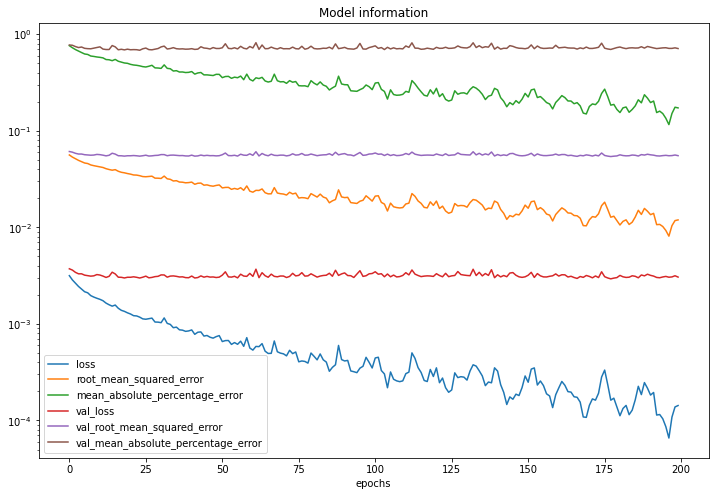

In [12]:
loss_df = pd.DataFrame(best_model.history.history)

loss_df.plot(figsize=(12,8), )
plt.title("Model information")
plt.xlabel("epochs")
plt.yscale('log')
plt.show()

In [15]:
from sklearn import metrics

y_pred = best_model.predict(X_test)
var_score = metrics.explained_variance_score(y_test,y_pred)

# compute the accuracy of the model 
print('Variance score:', var_score)
print('\nRMSE:',loss_df['root_mean_squared_error'].tail(1))
print('\nval RMSE:',loss_df['val_root_mean_squared_error'].tail(1))
print('\nTrain Loss:',loss_df['loss'].tail(1))
print('\nTest Loss:',loss_df['val_loss'].tail(1))
print('\nMAPE:',loss_df['mean_absolute_percentage_error'].tail(1))
print('\nval MAPE:',loss_df['val_mean_absolute_percentage_error'].tail(1))

Variance score: 0.8977971310456871

RMSE: 199    0.011951
Name: root_mean_squared_error, dtype: float64

val RMSE: 199    0.055283
Name: val_root_mean_squared_error, dtype: float64

Train Loss: 199    0.000143
Name: loss, dtype: float64

Test Loss: 199    0.003056
Name: val_loss, dtype: float64

MAPE: 199    0.172703
Name: mean_absolute_percentage_error, dtype: float64

val MAPE: 199    0.711379
Name: val_mean_absolute_percentage_error, dtype: float64
